In [1]:
# import pandas as pd
# #import numpy as npimport xlrd as xd
# from numpy.random import RandomState
# import  os

# # 依次建立成长力、筹资力、流动性、清偿力四大财务风险指标；20180823午
# # 加载全部数据包括四个模型数据,数据预处理
# #load_data = pd.read_excel("./dataSets/DEA三级到二级.xlsx", encoding="gbk")

# raw_data = pd.read_csv("./dataSets/raw_data.csv", encoding="gbk")
# col_cz  = ["营业收入增长率","总资产增长率","净资产收益率","总资本盈利率","现金收入比","购建固定资产及无形资产和其他长期资产支付的现金（"]
# # # col_czi = ["纳税信用等级","财务费用率","产权比率","速动比率","现金比率","现金流量债务比"]
# # col_ld  = ["流动资产周转率","应收账款周转率","流动资产合计","非流动资产合计","流动负债合计","营运资本周转率"]
# # # col_qc  = ["流动资产","流动负债","资产总计","净利润","所得税","经营现金流量净额"]
# # # # 各指标特征
# CZ_features  =  raw_data.loc[:, col_cz]
# # # CZI_features =  raw_data.loc[:, col_czi]
# # LD_features  =  raw_data.loc[:, col_ld]
# # # QC_features  =  raw_data.loc[:, col_qc]
# # # # 各指标 输出
# CZ_y  = raw_data.loc[:,["成长力"]]
# # CZI_y = raw_data.loc[:,["筹资力"]]
# LD_y  = raw_data.loc[:,["流动性"]]
# # QC_y  = raw_data.loc[:,["清偿力"]]

In [2]:
import tensorflow as tf
import  os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("tensorflow运行版本：" + tf.__version__)
# CNN 回归预测
sess = tf.Session()
#变厚矩阵
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name="w")
#偏置
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name="b")

#卷积处理 变厚过程
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#pool 长宽缩小一倍
def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# define placeholder for inputs to network
xs = tf.placeholder("float", shape=[None, 6], name = 'input_x') #原始数据的维度：9
ys = tf.placeholder("float", shape=[None, 1])#输出数据为维度：1
 
keep_prob = tf.placeholder(tf.float32, name="keep_prob")  # dropout的比例

# -1 数据数量不定2*3*1通道为1
x_image = tf.reshape(xs, [-1, 2, 3, 1])  # 原始数据16变成二维图片4*4



#  conv1 layer  第一卷积层
W_conv1 = weight_variable([2, 2, 1, 12])  # 卷积核大小patch 2x2, 图像通道数in size 1, 卷积核数目out size 6,
#  每个卷积核对应一个偏置量
b_conv1 = bias_variable([12])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # output size 2x2x32，长宽不变，高度为32的三维图像
#  h_pool1 = max_pool_2x2(h_conv1)     # output size 2x2x32 长宽缩小一倍


## conv2 layer  第二卷积层 6个通道卷积, 卷积出12个特征
W_conv2 = weight_variable([2, 2, 12, 24])  # patch 2x2, in size 32, out size 64
b_conv2 = bias_variable([24])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2) # 输入第一层的处理结果 输出shape 4*4*64

# fc1 layer ##  full connection 全连接层
W_fc1 = weight_variable([2*3*24, 144])  # 3x3 ，高度为64的三维图片，然后把它拉成512长的一维数组
b_fc1 = bias_variable([144])

h_pool2_flat = tf.reshape(h_conv2, [-1, 2*3*24])  # 把4*4，高度为64的三维图片拉成一维数组 降维处理
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)    # dropout层
# fc2 layer ## full connection

with tf.name_scope('output'):
    W_fc2 = weight_variable([144, 1])
    b_fc2 = bias_variable([1])  # 偏置
    # 最后的计算结果
    multi = tf.matmul(h_fc1_drop, W_fc2)
    pred = tf.add(multi, b_fc2, name="predict")

# 计算 predition与y 差距 所用方法很简单就是用 suare()平方,sum()求和,mean()平均值
cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(ys - pred), reduction_indices=[1]))
# 0.01学习效率,minimize(loss)减小loss误差
train_step = tf.train.AdamOptimizer(0.004).minimize(cross_entropy)
sess.run(tf.global_variables_initializer())

tensorflow运行版本：1.10.0


In [3]:
from functools import reduce
def pingjun(L=[]):
    a=reduce(lambda x,y:x+y,L)
    return a*1.0/len(L)
#获取平均数
def Get_Average(list):
   sum = 0
   for item in list:     
      sum += item  
   return sum/len(list)
 

In [4]:
# 训练模型
def train_model(x_train, y_train, iteration,model_name):
    error = []
    for i in range(iteration):
        sess.run(train_step, feed_dict={xs: x_train, ys: y_train, keep_prob: 0.6})
        err = sess.run(cross_entropy, feed_dict={xs: x_train, ys: y_train, keep_prob: 1.0})
        print(i, '误差=',err)  # 输出loss值
        error.append(err) 
    # 计算平均误差
    ave_error = Get_Average(error)
    print("平均误差为：%f " % ave_error)   
    # 保存模型
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['output/predict'])
    with tf.gfile.FastGFile(model_name, mode='wb') as f:
        f.write(output_graph_def.SerializeToString())
        print("Model Save succesfull!")

In [6]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
###########以司法风险为例进行模型训练##########################
raw_data = pd.read_csv("./dataSets/raw_data.csv", encoding="gbk")
out_data = pd.read_csv("./dataSets/output_data.csv", encoding="gbk")
raw_data  = raw_data.fillna(0)
#col_n = ['经营力方面---财务风险-盈利能力-销售净利率','财务风险-盈利能力-总资产报酬率', '财务风险-盈利能力-净资产收益率','财务风险-资产利用-存货周转率'
 #     ,'财务风险-资产利用-总资产周转率', '财务风险-资产利用-成本费用利润率']

col_ns = ["司法方面---经营风险-司法风险-诉讼数量","经营风险-其它风险-经营异常次数","经营风险-其它风险-行政处罚次数","经营风险-其它风险-动产质押次数","经营风险-其它风险-自身风险","经营风险-其它风险-周边风险"]
#jingying =  raw_data.loc[:594, col_n].values
sifa = raw_data.loc[:594, col_ns].values
#jy_Y = out_data.loc[:594,["经营"]].values
sf_Y = out_data.loc[:594,["司法"]].values

#jingying_test =  raw_data.loc[594:696, col_n]
sifa_test = raw_data.loc[594:696, col_ns].values
#jy_Y_test = out_data.loc[594:696,["经营"]].values
sf_Y_test = out_data.loc[594:696,["司法"]].values



# 切分训练测试数据
from sklearn.model_selection import train_test_split
def split_x_y(x,y_data):
    x_train, x_test, y_train, y_test = train_test_split(
    x, y_data, train_size=1, random_state=123) # 参数test_size设置训练集占比
    return x_train, x_test, y_train, y_test


In [7]:
from sklearn import preprocessing
x_train, x_test, y_train, y_test = split_x_y(sifa, sf_Y)

/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:

#  该类的好处在于可以保存训练集中的参数（均值、方差）直接使用其对象转换测试集数据
ss_x = preprocessing.StandardScaler()
# 先拟合再标准化训练集数据
train_x_disorder = ss_x.fit_transform(x_train)
# 使用上面所得均值和方差直接归一化测试集数据
test_x_disorder = ss_x.transform(x_test)

ss_y = preprocessing.StandardScaler()
train_y_disorder = ss_y.fit_transform(y_train.reshape(-1, 1))
                                      
test_y_disorder = ss_y.transform(y_test.reshape(-1, 1))

/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
# 训练
train_model(train_x_disorder,train_y_disorder , 10000, 'sf.pb')

0 误差= 0.0963332
1 误差= 0.0282882
2 误差= 0.0193586
3 误差= 0.0634246
4 误差= 0.0442888
5 误差= 0.0248902
6 误差= 0.00951812
7 误差= 0.00473407
8 误差= 0.000175624
9 误差= 0.00331425
10 误差= 0.0154881
11 误差= 0.0218163
12 误差= 0.0238225
13 误差= 0.0268
14 误差= 0.0237733
15 误差= 0.0256822
16 误差= 0.0187543
17 误差= 0.00781755
18 误差= 0.000371284
19 误差= 0.00161074
20 误差= 0.00859185
21 误差= 0.0172891
22 误差= 0.0276061
23 误差= 0.0299722
24 误差= 0.0264165
25 误差= 0.0178879
26 误差= 0.0106567
27 误差= 0.00543269
28 误差= 0.00193697
29 误差= 0.000310312
30 误差= 2.14734e-05
31 误差= 0.000463317
32 误差= 0.00118895
33 误差= 0.00195481
34 误差= 0.0034377
35 误差= 0.00439357
36 误差= 0.00327196
37 误差= 0.00173737
38 误差= 0.000808784
39 误差= 6.1095e-07
40 误差= 0.000475548
41 误差= 0.00260204
42 误差= 0.00562251
43 误差= 0.00831694
44 误差= 0.0112733
45 误差= 0.0112959
46 误差= 0.00992867
47 误差= 0.00809902
48 误差= 0.00618824
49 误差= 0.00437857
50 误差= 0.001801
51 误差= 0.000263659
52 误差= 8.75848e-05
53 误差= 0.000924509
54 误差= 0.00284713
55 误差= 0.00500291
56 误差= 0.00610238
5

441 误差= 3.94954e-06
442 误差= 2.81488e-06
443 误差= 9.54033e-06
444 误差= 2.36541e-05
445 误差= 2.9091e-05
446 误差= 3.05158e-05
447 误差= 1.77566e-05
448 误差= 9.35397e-06
449 误差= 6.5354e-06
450 误差= 2.86828e-06
451 误差= 2.67439e-09
452 误差= 4.02207e-06
453 误差= 9.35876e-06
454 误差= 6.97083e-06
455 误差= 7.85156e-07
456 误差= 8.94353e-07
457 误差= 5.5695e-06
458 误差= 5.62531e-06
459 误差= 2.03461e-06
460 误差= 1.10064e-08
461 误差= 1.8839e-06
462 误差= 9.30927e-06
463 误差= 3.51912e-05
464 误差= 6.23082e-05
465 误差= 0.000102104
466 误差= 0.000138762
467 误差= 0.000151101
468 误差= 0.00016794
469 误差= 0.000163123
470 误差= 0.000131631
471 误差= 0.000117297
472 误差= 9.35106e-05
473 误差= 9.58853e-05
474 误差= 0.000117221
475 误差= 0.00012487
476 误差= 0.000103983
477 误差= 6.67321e-05
478 误差= 2.94988e-05
479 误差= 3.9536e-06
480 误差= 3.97039e-06
481 误差= 2.28148e-05
482 误差= 4.06989e-05
483 误差= 6.39819e-05
484 误差= 9.72089e-05
485 误差= 0.000137213
486 误差= 0.000152182
487 误差= 0.000155409
488 误差= 0.000152722
489 误差= 0.000151014
490 误差= 0.000115319
491 误差=

857 误差= 1.125e-05
858 误差= 8.22677e-06
859 误差= 2.565e-06
860 误差= 3.53555e-07
861 误差= 1.81954e-07
862 误差= 3.48531e-07
863 误差= 1.01428e-06
864 误差= 9.32209e-07
865 误差= 1.70325e-06
866 误差= 4.97393e-06
867 误差= 9.41756e-06
868 误差= 1.34418e-05
869 误差= 1.59725e-05
870 误差= 1.66325e-05
871 误差= 2.02064e-05
872 误差= 2.36544e-05
873 误差= 2.21263e-05
874 误差= 1.80505e-05
875 误差= 1.13726e-05
876 误差= 5.14939e-06
877 误差= 1.92171e-06
878 误差= 4.69994e-07
879 误差= 3.27639e-08
880 误差= 4.98634e-07
881 误差= 4.95718e-07
882 误差= 1.44345e-07
883 误差= 2.98745e-08
884 误差= 4.7392e-07
885 误差= 1.03861e-07
886 误差= 1.02189e-07
887 误差= 1.07354e-06
888 误差= 3.12845e-06
889 误差= 7.72435e-06
890 误差= 1.45553e-05
891 误差= 1.95576e-05
892 误差= 2.00797e-05
893 误差= 1.90292e-05
894 误差= 1.75122e-05
895 误差= 1.16204e-05
896 误差= 5.86762e-06
897 误差= 1.586e-06
898 误差= 1.19374e-07
899 误差= 1.46288e-07
900 误差= 3.36489e-06
901 误差= 1.00064e-05
902 误差= 1.649e-05
903 误差= 2.1143e-05
904 误差= 2.38482e-05
905 误差= 2.39796e-05
906 误差= 1.95774e-05
907 误差= 1.

1272 误差= 1.79664e-06
1273 误差= 1.66541e-06
1274 误差= 1.0822e-06
1275 误差= 4.78739e-07
1276 误差= 3.37572e-07
1277 误差= 2.84377e-07
1278 误差= 4.52788e-07
1279 误差= 9.11002e-07
1280 误差= 1.66037e-06
1281 误差= 1.93636e-06
1282 误差= 2.03425e-06
1283 误差= 2.36526e-06
1284 误差= 3.65462e-06
1285 误差= 4.81855e-06
1286 误差= 7.55836e-06
1287 误差= 9.68031e-06
1288 误差= 1.51717e-05
1289 误差= 1.88671e-05
1290 误差= 2.11125e-05
1291 误差= 2.14118e-05
1292 误差= 2.08851e-05
1293 误差= 1.8163e-05
1294 误差= 1.40017e-05
1295 误差= 8.21716e-06
1296 误差= 3.90494e-06
1297 误差= 9.08003e-07
1298 误差= 1.22658e-08
1299 误差= 3.19566e-07
1300 误差= 1.41708e-06
1301 误差= 2.72147e-06
1302 误差= 3.33273e-06
1303 误差= 3.40691e-06
1304 误差= 3.01894e-06
1305 误差= 2.57036e-06
1306 误差= 1.97122e-06
1307 误差= 6.75032e-07
1308 误差= 6.38015e-09
1309 误差= 2.3498e-07
1310 误差= 8.05237e-07
1311 误差= 1.90133e-06
1312 误差= 2.86837e-06
1313 误差= 3.90859e-06
1314 误差= 4.4968e-06
1315 误差= 4.35918e-06
1316 误差= 3.43688e-06
1317 误差= 3.04338e-06
1318 误差= 2.10581e-06
1319 误差= 1.282e-0

1682 误差= 2.40942e-07
1683 误差= 4.26646e-07
1684 误差= 5.54923e-07
1685 误差= 5.8815e-07
1686 误差= 4.40801e-07
1687 误差= 2.46915e-07
1688 误差= 3.26292e-08
1689 误差= 5.51371e-11
1690 误差= 5.5945e-09
1691 误差= 5.2877e-08
1692 误差= 1.38938e-07
1693 误差= 1.51984e-07
1694 误差= 1.87763e-07
1695 误差= 1.8537e-07
1696 误差= 8.83538e-08
1697 误差= 3.38764e-08
1698 误差= 1.1941e-09
1699 误差= 1.83007e-08
1700 误差= 2.1789e-08
1701 误差= 8.76685e-09
1702 误差= 2.25725e-09
1703 误差= 2.18886e-08
1704 误差= 6.28056e-08
1705 误差= 1.08716e-07
1706 误差= 1.05526e-07
1707 误差= 1.41101e-07
1708 误差= 3.74224e-07
1709 误差= 3.01594e-07
1710 误差= 3.45485e-07
1711 误差= 3.25401e-07
1712 误差= 1.99047e-07
1713 误差= 1.39758e-07
1714 误差= 6.09578e-08
1715 误差= 2.85316e-08
1716 误差= 6.00466e-09
1717 误差= 4.30269e-09
1718 误差= 8.44303e-08
1719 误差= 1.96982e-07
1720 误差= 2.71049e-07
1721 误差= 3.01751e-07
1722 误差= 3.09402e-07
1723 误差= 2.29404e-07
1724 误差= 2.65482e-07
1725 误差= 1.79022e-07
1726 误差= 4.8804e-08
1727 误差= 6.71635e-10
1728 误差= 3.20151e-08
1729 误差= 5.59614e-08

2094 误差= 6.55413e-08
2095 误差= 3.59028e-08
2096 误差= 2.34357e-08
2097 误差= 2.05348e-09
2098 误差= 7.12199e-10
2099 误差= 1.5678e-08
2100 误差= 1.91207e-08
2101 误差= 1.73296e-08
2102 误差= 1.10879e-08
2103 误差= 9.0212e-09
2104 误差= 1.11351e-09
2105 误差= 2.09305e-09
2106 误差= 5.54737e-09
2107 误差= 1.47221e-08
2108 误差= 1.74735e-08
2109 误差= 3.04319e-08
2110 误差= 1.95959e-08
2111 误差= 9.23868e-09
2112 误差= 1.30169e-09
2113 误差= 2.21407e-10
2114 误差= 8.1357e-10
2115 误差= 6.42777e-09
2116 误差= 1.85112e-08
2117 误差= 2.83163e-08
2118 误差= 1.26112e-08
2119 误差= 2.64485e-09
2120 误差= 6.01932e-10
2121 误差= 3.28378e-11
2122 误差= 1.9222e-09
2123 误差= 1.24266e-08
2124 误差= 3.23296e-08
2125 误差= 4.59852e-08
2126 误差= 4.58268e-08
2127 误差= 3.40455e-08
2128 误差= 2.29002e-08
2129 误差= 1.43416e-08
2130 误差= 7.49238e-09
2131 误差= 2.95733e-09
2132 误差= 5.32449e-13
2133 误差= 4.48164e-10
2134 误差= 2.84626e-09
2135 误差= 3.85538e-09
2136 误差= 1.76008e-08
2137 误差= 4.73187e-08
2138 误差= 9.97098e-08
2139 误差= 1.9741e-07
2140 误差= 3.50205e-07
2141 误差= 3.40136e-

2507 误差= 1.62642e-07
2508 误差= 1.1417e-07
2509 误差= 7.15873e-08
2510 误差= 2.97698e-08
2511 误差= 9.15268e-09
2512 误差= 7.43662e-11
2513 误差= 3.37246e-09
2514 误差= 1.65021e-08
2515 误差= 3.04438e-08
2516 误差= 5.70021e-08
2517 误差= 7.43431e-08
2518 误差= 8.28159e-08
2519 误差= 9.39542e-08
2520 误差= 1.21686e-07
2521 误差= 1.43827e-07
2522 误差= 1.5641e-07
2523 误差= 1.58125e-07
2524 误差= 1.36314e-07
2525 误差= 9.72522e-08
2526 误差= 6.33142e-08
2527 误差= 3.66007e-08
2528 误差= 1.67046e-08
2529 误差= 3.08631e-09
2530 误差= 2.53579e-11
2531 误差= 4.23827e-09
2532 误差= 1.58288e-08
2533 误差= 3.81806e-08
2534 误差= 7.48745e-08
2535 误差= 1.02716e-07
2536 误差= 1.12794e-07
2537 误差= 1.14668e-07
2538 误差= 9.48621e-08
2539 误差= 7.1026e-08
2540 误差= 5.97661e-08
2541 误差= 4.72073e-08
2542 误差= 2.78419e-08
2543 误差= 1.85854e-08
2544 误差= 1.05552e-08
2545 误差= 2.82295e-09
2546 误差= 1.14654e-10
2547 误差= 4.33044e-09
2548 误差= 1.47262e-08
2549 误差= 3.2312e-08
2550 误差= 5.33491e-08
2551 误差= 7.24908e-08
2552 误差= 9.55799e-08
2553 误差= 1.16234e-07
2554 误差= 1.33853e

2917 误差= 2.06011e-10
2918 误差= 4.51517e-09
2919 误差= 1.72238e-08
2920 误差= 3.49846e-08
2921 误差= 6.09629e-08
2922 误差= 8.90928e-08
2923 误差= 1.15112e-07
2924 误差= 1.29055e-07
2925 误差= 1.17498e-07
2926 误差= 1.03134e-07
2927 误差= 8.06474e-08
2928 误差= 6.03417e-08
2929 误差= 3.65085e-08
2930 误差= 1.58491e-08
2931 误差= 4.79693e-09
2932 误差= 5.01736e-10
2933 误差= 7.58391e-11
2934 误差= 5.119e-10
2935 误差= 1.14257e-09
2936 误差= 1.72458e-09
2937 误差= 2.41605e-09
2938 误差= 5.8405e-09
2939 误差= 9.24097e-09
2940 误差= 1.14346e-08
2941 误差= 1.24598e-08
2942 误差= 1.31976e-08
2943 误差= 1.12364e-08
2944 误差= 7.51529e-09
2945 误差= 4.66189e-09
2946 误差= 2.99513e-09
2947 误差= 2.02562e-09
2948 误差= 7.58434e-10
2949 误差= 8.44649e-10
2950 误差= 1.83346e-09
2951 误差= 2.3216e-09
2952 误差= 3.59661e-09
2953 误差= 4.25915e-09
2954 误差= 5.35781e-09
2955 误差= 4.7736e-09
2956 误差= 2.76176e-09
2957 误差= 1.04064e-09
2958 误差= 3.11065e-10
2959 误差= 2.51438e-11
2960 误差= 2.43643e-10
2961 误差= 1.60578e-09
2962 误差= 6.86507e-09
2963 误差= 1.28654e-08
2964 误差= 2.19946e-

3332 误差= 8.55858e-09
3333 误差= 6.48081e-09
3334 误差= 3.87091e-09
3335 误差= 1.42494e-09
3336 误差= 2.38879e-10
3337 误差= 1.75206e-10
3338 误差= 9.50473e-10
3339 误差= 1.87706e-09
3340 误差= 4.26327e-09
3341 误差= 9.02804e-09
3342 误差= 1.33481e-08
3343 误差= 1.87804e-08
3344 误差= 2.60716e-08
3345 误差= 2.82957e-08
3346 误差= 2.72692e-08
3347 误差= 2.36319e-08
3348 误差= 1.80246e-08
3349 误差= 1.14315e-08
3350 误差= 6.18376e-09
3351 误差= 1.4402e-09
3352 误差= 2.48938e-12
3353 误差= 1.00179e-09
3354 误差= 2.95587e-09
3355 误差= 6.74792e-09
3356 误差= 1.23439e-08
3357 误差= 1.88743e-08
3358 误差= 2.26184e-08
3359 误差= 2.45133e-08
3360 误差= 2.35329e-08
3361 误差= 2.16823e-08
3362 误差= 1.70752e-08
3363 误差= 1.49337e-08
3364 误差= 1.24931e-08
3365 误差= 1.06637e-08
3366 误差= 9.76046e-09
3367 误差= 8.25321e-09
3368 误差= 7.28255e-09
3369 误差= 5.81718e-09
3370 误差= 2.7826e-09
3371 误差= 6.40969e-10
3372 误差= 1.20311e-13
3373 误差= 5.30975e-10
3374 误差= 2.15222e-09
3375 误差= 4.22395e-09
3376 误差= 5.89015e-09
3377 误差= 7.93336e-09
3378 误差= 7.20207e-09
3379 误差= 9.1019

3746 误差= 1.49449e-13
3747 误差= 9.1235e-11
3748 误差= 1.86112e-10
3749 误差= 3.1755e-10
3750 误差= 4.73673e-10
3751 误差= 8.01077e-10
3752 误差= 1.54327e-09
3753 误差= 1.69709e-09
3754 误差= 1.65324e-09
3755 误差= 8.66068e-10
3756 误差= 1.20926e-10
3757 误差= 1.49121e-11
3758 误差= 1.24951e-10
3759 误差= 1.82179e-10
3760 误差= 6.3116e-11
3761 误差= 4.35345e-11
3762 误差= 3.28648e-11
3763 误差= 3.15773e-13
3764 误差= 6.04918e-11
3765 误差= 3.23107e-10
3766 误差= 1.33079e-09
3767 误差= 3.15392e-09
3768 误差= 4.57533e-09
3769 误差= 5.62884e-09
3770 误差= 5.79746e-09
3771 误差= 5.85775e-09
3772 误差= 5.71961e-09
3773 误差= 5.23319e-09
3774 误差= 3.70256e-09
3775 误差= 2.81005e-09
3776 误差= 1.41214e-09
3777 误差= 6.25704e-10
3778 误差= 8.02663e-11
3779 误差= 3.59194e-12
3780 误差= 2.0879e-11
3781 误差= 1.37544e-10
3782 误差= 3.34744e-10
3783 误差= 3.35595e-10
3784 误差= 7.37383e-10
3785 误差= 1.17182e-09
3786 误差= 2.18562e-09
3787 误差= 2.80597e-09
3788 误差= 2.96492e-09
3789 误差= 2.21089e-09
3790 误差= 1.42582e-09
3791 误差= 8.7597e-10
3792 误差= 9.64002e-10
3793 误差= 1.40688e-

4156 误差= 2.90439e-11
4157 误差= 9.4847e-12
4158 误差= 9.25216e-17
4159 误差= 4.31542e-12
4160 误差= 3.73764e-11
4161 误差= 1.1937e-10
4162 误差= 4.50777e-10
4163 误差= 7.3922e-10
4164 误差= 1.02882e-09
4165 误差= 9.5404e-10
4166 误差= 1.13853e-09
4167 误差= 1.34349e-09
4168 误差= 1.40531e-09
4169 误差= 1.49792e-09
4170 误差= 1.30649e-09
4171 误差= 1.0447e-09
4172 误差= 5.65917e-10
4173 误差= 1.60354e-10
4174 误差= 6.66577e-12
4175 误差= 6.11981e-14
4176 误差= 1.57707e-12
4177 误差= 5.48415e-12
4178 误差= 6.8634e-11
4179 误差= 1.01982e-10
4180 误差= 9.24002e-11
4181 误差= 9.1104e-12
4182 误差= 5.08427e-11
4183 误差= 9.97761e-11
4184 误差= 1.8879e-10
4185 误差= 2.09145e-10
4186 误差= 7.71482e-11
4187 误差= 6.94562e-12
4188 误差= 1.59843e-10
4189 误差= 4.03973e-10
4190 误差= 8.9657e-10
4191 误差= 1.17005e-09
4192 误差= 1.57288e-09
4193 误差= 1.52955e-09
4194 误差= 1.44543e-09
4195 误差= 9.88161e-10
4196 误差= 4.44252e-10
4197 误差= 2.1028e-10
4198 误差= 1.59108e-10
4199 误差= 7.84206e-11
4200 误差= 1.10784e-11
4201 误差= 5.05983e-12
4202 误差= 3.43826e-11
4203 误差= 7.54169e-11
42

4571 误差= 1.73342e-10
4572 误差= 1.24096e-10
4573 误差= 1.49657e-11
4574 误差= 1.66616e-11
4575 误差= 5.29739e-11
4576 误差= 7.83694e-11
4577 误差= 7.34184e-11
4578 误差= 8.54827e-11
4579 误差= 1.14024e-10
4580 误差= 8.61641e-11
4581 误差= 6.39387e-11
4582 误差= 3.33362e-11
4583 误差= 4.52371e-11
4584 误差= 1.26123e-10
4585 误差= 1.97537e-10
4586 误差= 2.1948e-10
4587 误差= 1.33695e-10
4588 误差= 8.80721e-11
4589 误差= 7.27984e-11
4590 误差= 5.64365e-11
4591 误差= 3.04115e-11
4592 误差= 1.1173e-12
4593 误差= 1.01446e-10
4594 误差= 2.40274e-10
4595 误差= 3.6138e-10
4596 误差= 4.44221e-10
4597 误差= 3.16083e-10
4598 误差= 1.09822e-10
4599 误差= 2.05076e-11
4600 误差= 8.54223e-12
4601 误差= 1.2703e-10
4602 误差= 3.1372e-10
4603 误差= 3.33496e-10
4604 误差= 3.93541e-10
4605 误差= 4.44676e-10
4606 误差= 4.00391e-10
4607 误差= 2.01465e-10
4608 误差= 3.71979e-11
4609 误差= 3.31654e-11
4610 误差= 3.45089e-10
4611 误差= 7.34156e-10
4612 误差= 1.24389e-09
4613 误差= 1.33017e-09
4614 误差= 1.15841e-09
4615 误差= 8.12095e-10
4616 误差= 6.069e-10
4617 误差= 4.30801e-10
4618 误差= 4.01248e-10

4966 误差= 6.42166e-11
4967 误差= 8.13628e-11
4968 误差= 7.67336e-11
4969 误差= 4.79954e-11
4970 误差= 1.87036e-12
4971 误差= 7.93469e-12
4972 误差= 4.41231e-11
4973 误差= 5.00976e-11
4974 误差= 2.65586e-11
4975 误差= 5.81158e-12
4976 误差= 7.40905e-12
4977 误差= 4.18224e-14
4978 误差= 1.33132e-12
4979 误差= 1.87703e-11
4980 误差= 1.67288e-11
4981 误差= 3.14676e-11
4982 误差= 1.49656e-11
4983 误差= 8.49551e-13
4984 误差= 1.10788e-11
4985 误差= 3.80374e-11
4986 误差= 8.80293e-11
4987 误差= 9.3499e-11
4988 误差= 5.96169e-11
4989 误差= 3.99442e-11
4990 误差= 1.07749e-11
4991 误差= 2.01422e-12
4992 误差= 3.93403e-11
4993 误差= 1.34929e-10
4994 误差= 1.66237e-10
4995 误差= 1.58044e-10
4996 误差= 1.61205e-10
4997 误差= 2.47037e-10
4998 误差= 3.48799e-10
4999 误差= 4.43193e-10
5000 误差= 5.11556e-10
5001 误差= 5.01113e-10
5002 误差= 3.4018e-10
5003 误差= 1.99017e-10
5004 误差= 1.45102e-10
5005 误差= 1.03707e-10
5006 误差= 1.06979e-10
5007 误差= 1.23822e-10
5008 误差= 1.56867e-10
5009 误差= 1.08555e-10
5010 误差= 4.77492e-11
5011 误差= 7.94697e-13
5012 误差= 2.29713e-11
5013 误差= 5.4414

5364 误差= 4.90203e-10
5365 误差= 5.76173e-10
5366 误差= 4.68224e-10
5367 误差= 2.61042e-10
5368 误差= 1.20148e-10
5369 误差= 7.62349e-11
5370 误差= 1.99987e-11
5371 误差= 5.30421e-12
5372 误差= 2.31489e-14
5373 误差= 1.20271e-11
5374 误差= 2.85721e-12
5375 误差= 5.56057e-12
5376 误差= 3.94813e-12
5377 误差= 3.1545e-12
5378 误差= 1.39913e-12
5379 误差= 3.39374e-12
5380 误差= 2.64406e-12
5381 误差= 2.67786e-12
5382 误差= 7.91062e-12
5383 误差= 1.07409e-11
5384 误差= 3.83048e-11
5385 误差= 4.99674e-11
5386 误差= 5.94445e-11
5387 误差= 7.4268e-11
5388 误差= 3.60073e-11
5389 误差= 4.80489e-12
5390 误差= 3.70731e-12
5391 误差= 3.27472e-12
5392 误差= 4.79427e-12
5393 误差= 3.61947e-11
5394 误差= 2.25682e-11
5395 误差= 2.434e-11
5396 误差= 1.99974e-12
5397 误差= 3.03244e-12
5398 误差= 6.46714e-14
5399 误差= 1.11657e-11
5400 误差= 5.79979e-11
5401 误差= 8.85293e-11
5402 误差= 1.07143e-10
5403 误差= 6.76854e-11
5404 误差= 2.56176e-11
5405 误差= 2.49339e-11
5406 误差= 4.29984e-11
5407 误差= 3.87346e-11
5408 误差= 4.32555e-11
5409 误差= 4.7465e-11
5410 误差= 6.99183e-11
5411 误差= 2.58973e-

5763 误差= 2.09161e-11
5764 误差= 7.66691e-12
5765 误差= 9.95016e-13
5766 误差= 1.56123e-11
5767 误差= 6.88156e-11
5768 误差= 1.38714e-10
5769 误差= 1.68063e-10
5770 误差= 1.5821e-10
5771 误差= 1.0017e-10
5772 误差= 3.64477e-11
5773 误差= 9.48721e-12
5774 误差= 4.61338e-12
5775 误差= 3.16532e-13
5776 误差= 2.07498e-11
5777 误差= 8.76319e-11
5778 误差= 9.85764e-11
5779 误差= 6.8444e-11
5780 误差= 2.41043e-11
5781 误差= 3.1969e-12
5782 误差= 1.7246e-13
5783 误差= 3.72508e-12
5784 误差= 1.219e-11
5785 误差= 3.47461e-11
5786 误差= 6.56312e-11
5787 误差= 8.92206e-11
5788 误差= 1.33829e-10
5789 误差= 1.06257e-10
5790 误差= 2.11361e-11
5791 误差= 1.27716e-13
5792 误差= 2.34345e-11
5793 误差= 6.94352e-11
5794 误差= 1.07954e-10
5795 误差= 1.00825e-10
5796 误差= 5.22404e-11
5797 误差= 2.86917e-11
5798 误差= 2.94482e-11
5799 误差= 1.24478e-11
5800 误差= 1.33019e-12
5801 误差= 4.16328e-11
5802 误差= 1.13863e-10
5803 误差= 1.46165e-10
5804 误差= 1.66776e-10
5805 误差= 2.02062e-10
5806 误差= 1.71596e-10
5807 误差= 1.05192e-10
5808 误差= 4.40929e-11
5809 误差= 3.97898e-12
5810 误差= 6.20741e-12

6162 误差= 5.14425e-11
6163 误差= 2.34475e-12
6164 误差= 2.00273e-11
6165 误差= 1.05419e-10
6166 误差= 2.32834e-10
6167 误差= 2.69467e-10
6168 误差= 2.09915e-10
6169 误差= 1.07755e-10
6170 误差= 2.61132e-11
6171 误差= 1.41862e-13
6172 误差= 4.83047e-12
6173 误差= 1.73509e-11
6174 误差= 1.96803e-11
6175 误差= 3.42238e-11
6176 误差= 3.80268e-11
6177 误差= 6.2187e-11
6178 误差= 4.89612e-11
6179 误差= 1.1016e-11
6180 误差= 4.68757e-13
6181 误差= 9.83575e-12
6182 误差= 5.12859e-12
6183 误差= 2.08142e-12
6184 误差= 1.244e-12
6185 误差= 4.67502e-12
6186 误差= 8.29894e-12
6187 误差= 7.74656e-12
6188 误差= 2.00607e-12
6189 误差= 1.54489e-12
6190 误差= 1.9107e-11
6191 误差= 3.34573e-11
6192 误差= 4.41646e-11
6193 误差= 4.13908e-11
6194 误差= 2.22906e-11
6195 误差= 1.85623e-11
6196 误差= 1.32583e-12
6197 误差= 1.59259e-11
6198 误差= 7.7799e-11
6199 误差= 1.13359e-10
6200 误差= 1.0792e-10
6201 误差= 4.91962e-11
6202 误差= 3.39414e-12
6203 误差= 4.06516e-11
6204 误差= 1.92096e-10
6205 误差= 2.85583e-10
6206 误差= 2.81026e-10
6207 误差= 1.92187e-10
6208 误差= 5.05268e-11
6209 误差= 6.97205e-12

6564 误差= 4.42671e-11
6565 误差= 6.24594e-11
6566 误差= 4.39012e-11
6567 误差= 2.05759e-11
6568 误差= 1.37242e-11
6569 误差= 4.44668e-12
6570 误差= 3.09032e-13
6571 误差= 7.13278e-14
6572 误差= 1.16375e-11
6573 误差= 1.45952e-11
6574 误差= 7.04529e-12
6575 误差= 2.06002e-13
6576 误差= 1.42508e-11
6577 误差= 3.54523e-11
6578 误差= 2.41173e-11
6579 误差= 9.71723e-12
6580 误差= 1.58412e-13
6581 误差= 5.46858e-12
6582 误差= 1.81218e-11
6583 误差= 1.14752e-11
6584 误差= 4.01713e-12
6585 误差= 8.53301e-13
6586 误差= 1.41783e-11
6587 误差= 3.51273e-11
6588 误差= 2.17594e-11
6589 误差= 8.52181e-12
6590 误差= 1.17497e-13
6591 误差= 5.85727e-12
6592 误差= 1.82687e-11
6593 误差= 1.05818e-11
6594 误差= 7.99889e-12
6595 误差= 3.17888e-12
6596 误差= 1.49496e-12
6597 误差= 3.41766e-12
6598 误差= 1.09739e-11
6599 误差= 2.06286e-11
6600 误差= 1.29093e-11
6601 误差= 2.74192e-12
6602 误差= 3.27278e-12
6603 误差= 4.32474e-11
6604 误差= 1.23519e-10
6605 误差= 1.5568e-10
6606 误差= 9.65631e-11
6607 误差= 3.14908e-11
6608 误差= 2.55336e-13
6609 误差= 3.77747e-11
6610 误差= 1.08922e-10
6611 误差= 1.389

6977 误差= 1.05298e-11
6978 误差= 1.48429e-11
6979 误差= 4.24144e-12
6980 误差= 6.89474e-17
6981 误差= 1.24837e-12
6982 误差= 5.04945e-14
6983 误差= 1.09838e-12
6984 误差= 2.45016e-12
6985 误差= 5.88861e-12
6986 误差= 1.49732e-11
6987 误差= 1.54514e-11
6988 误差= 8.70551e-12
6989 误差= 2.43834e-14
6990 误差= 9.28491e-12
6991 误差= 2.30138e-11
6992 误差= 3.45553e-11
6993 误差= 4.22174e-11
6994 误差= 2.63549e-11
6995 误差= 1.48757e-12
6996 误差= 8.17977e-12
6997 误差= 2.70289e-11
6998 误差= 1.81035e-11
6999 误差= 7.19338e-12
7000 误差= 2.31683e-12
7001 误差= 1.14414e-12
7002 误差= 5.03342e-12
7003 误差= 1.51075e-11
7004 误差= 2.11046e-11
7005 误差= 2.01147e-11
7006 误差= 1.52518e-11
7007 误差= 1.13829e-11
7008 误差= 1.27779e-11
7009 误差= 2.84048e-12
7010 误差= 4.10483e-13
7011 误差= 2.62918e-14
7012 误差= 6.00465e-13
7013 误差= 1.50101e-12
7014 误差= 5.54272e-13
7015 误差= 7.59538e-13
7016 误差= 4.70745e-13
7017 误差= 6.72825e-12
7018 误差= 1.30919e-11
7019 误差= 1.86e-11
7020 误差= 1.43472e-11
7021 误差= 1.60547e-12
7022 误差= 7.38202e-12
7023 误差= 2.83515e-11
7024 误差= 2.06927

7392 误差= 8.39818e-15
7393 误差= 1.08799e-12
7394 误差= 5.93872e-13
7395 误差= 1.42775e-13
7396 误差= 7.61666e-14
7397 误差= 3.39344e-12
7398 误差= 6.24444e-12
7399 误差= 3.15668e-12
7400 误差= 6.62911e-14
7401 误差= 1.88879e-12
7402 误差= 3.04528e-13
7403 误差= 9.03859e-13
7404 误差= 6.67723e-12
7405 误差= 1.58214e-11
7406 误差= 2.68231e-11
7407 误差= 2.72637e-11
7408 误差= 2.09134e-11
7409 误差= 1.13644e-11
7410 误差= 3.2833e-12
7411 误差= 1.1464e-13
7412 误差= 1.02577e-12
7413 误差= 1.2004e-12
7414 误差= 5.55874e-13
7415 误差= 2.348e-13
7416 误差= 1.90075e-12
7417 误差= 7.84039e-13
7418 误差= 5.03954e-15
7419 误差= 1.00147e-13
7420 误差= 9.61814e-14
7421 误差= 5.57377e-13
7422 误差= 1.07363e-13
7423 误差= 2.90617e-15
7424 误差= 2.69765e-13
7425 误差= 6.87147e-13
7426 误差= 4.04901e-13
7427 误差= 2.50291e-13
7428 误差= 1.90076e-12
7429 误差= 9.39028e-12
7430 误差= 1.62888e-11
7431 误差= 2.06859e-11
7432 误差= 1.02268e-11
7433 误差= 9.7195e-13
7434 误差= 5.01354e-13
7435 误差= 3.17948e-12
7436 误差= 1.06868e-11
7437 误差= 5.35096e-12
7438 误差= 8.22595e-14
7439 误差= 7.96635e-1

7796 误差= 2.90605e-12
7797 误差= 1.59487e-12
7798 误差= 1.74696e-12
7799 误差= 3.22431e-12
7800 误差= 9.89762e-13
7801 误差= 2.66368e-15
7802 误差= 2.06144e-13
7803 误差= 1.0757e-12
7804 误差= 5.99582e-12
7805 误差= 9.27448e-12
7806 误差= 1.23952e-11
7807 误差= 1.99197e-12
7808 误差= 7.00269e-13
7809 误差= 1.98139e-13
7810 误差= 1.49642e-12
7811 误差= 9.86241e-13
7812 误差= 1.92914e-12
7813 误差= 1.66276e-11
7814 误差= 3.02507e-11
7815 误差= 1.28004e-11
7816 误差= 1.06468e-12
7817 误差= 1.44142e-11
7818 误差= 8.94467e-12
7819 误差= 1.24973e-12
7820 误差= 1.54131e-12
7821 误差= 7.17942e-12
7822 误差= 1.41761e-11
7823 误差= 1.17823e-11
7824 误差= 9.04335e-14
7825 误差= 2.84385e-12
7826 误差= 3.98179e-12
7827 误差= 9.10828e-13
7828 误差= 1.16696e-12
7829 误差= 8.36578e-12
7830 误差= 1.21236e-11
7831 误差= 6.80184e-12
7832 误差= 2.44747e-13
7833 误差= 1.04148e-11
7834 误差= 3.37186e-11
7835 误差= 3.62797e-11
7836 误差= 2.81553e-11
7837 误差= 6.22877e-12
7838 误差= 2.62799e-12
7839 误差= 2.20748e-11
7840 误差= 3.77786e-11
7841 误差= 4.01347e-11
7842 误差= 8.92283e-12
7843 误差= 2.631

8207 误差= 1.00721e-11
8208 误差= 1.30163e-11
8209 误差= 8.56261e-12
8210 误差= 1.85544e-12
8211 误差= 2.11406e-12
8212 误差= 1.11455e-11
8213 误差= 3.13038e-12
8214 误差= 1.30182e-13
8215 误差= 7.67704e-12
8216 误差= 1.28947e-11
8217 误差= 9.69207e-12
8218 误差= 2.81306e-12
8219 误差= 9.0464e-13
8220 误差= 2.59799e-13
8221 误差= 2.57565e-13
8222 误差= 3.07931e-13
8223 误差= 1.38068e-12
8224 误差= 8.4051e-17
8225 误差= 1.23012e-14
8226 误差= 1.23214e-12
8227 误差= 3.38293e-12
8228 误差= 1.46474e-12
8229 误差= 1.97988e-14
8230 误差= 5.02619e-13
8231 误差= 1.55815e-12
8232 误差= 5.66665e-15
8233 误差= 9.96206e-13
8234 误差= 9.64517e-13
8235 误差= 6.36086e-14
8236 误差= 1.9273e-12
8237 误差= 5.12909e-12
8238 误差= 1.53649e-12
8239 误差= 1.84582e-12
8240 误差= 1.25948e-11
8241 误差= 1.4466e-11
8242 误差= 4.31505e-12
8243 误差= 2.6713e-13
8244 误差= 7.00568e-12
8245 误差= 5.11772e-12
8246 误差= 2.84794e-13
8247 误差= 9.65639e-12
8248 误差= 1.75162e-11
8249 误差= 3.94258e-12
8250 误差= 4.02744e-12
8251 误差= 1.40178e-11
8252 误差= 1.19397e-11
8253 误差= 4.81771e-12
8254 误差= 1.40241e-

8613 误差= 2.36363e-10
8614 误差= 4.70826e-10
8615 误差= 9.58455e-11
8616 误差= 7.82906e-11
8617 误差= 2.16355e-10
8618 误差= 9.96545e-11
8619 误差= 1.67853e-11
8620 误差= 8.69781e-11
8621 误差= 1.61373e-10
8622 误差= 2.2823e-10
8623 误差= 1.69644e-10
8624 误差= 2.58263e-12
8625 误差= 6.18754e-12
8626 误差= 6.33389e-11
8627 误差= 2.89352e-11
8628 误差= 5.90181e-12
8629 误差= 9.41851e-11
8630 误差= 2.23194e-10
8631 误差= 6.25783e-11
8632 误差= 4.34715e-11
8633 误差= 2.08925e-11
8634 误差= 1.32167e-11
8635 误差= 3.02192e-11
8636 误差= 3.42105e-11
8637 误差= 8.65859e-12
8638 误差= 1.83719e-10
8639 误差= 8.29473e-11
8640 误差= 6.47147e-11
8641 误差= 3.34693e-10
8642 误差= 3.4632e-10
8643 误差= 9.69628e-11
8644 误差= 4.35216e-11
8645 误差= 2.17059e-10
8646 误差= 1.59241e-10
8647 误差= 5.35195e-15
8648 误差= 1.38224e-10
8649 误差= 3.08293e-10
8650 误差= 7.53903e-11
8651 误差= 8.85349e-11
8652 误差= 4.19806e-10
8653 误差= 1.96247e-10
8654 误差= 9.03189e-12
8655 误差= 8.62088e-11
8656 误差= 1.67308e-10
8657 误差= 1.13632e-11
8658 误差= 2.43206e-12
8659 误差= 8.67051e-12
8660 误差= 4.0256

9026 误差= 5.78808e-08
9027 误差= 1.96082e-07
9028 误差= 1.53617e-07
9029 误差= 6.82334e-10
9030 误差= 2.68154e-07
9031 误差= 3.05161e-07
9032 误差= 3.89976e-08
9033 误差= 8.30758e-07
9034 误差= 4.85752e-07
9035 误差= 1.24824e-08
9036 误差= 5.78165e-07
9037 误差= 3.3926e-07
9038 误差= 5.95606e-08
9039 误差= 6.91619e-07
9040 误差= 3.94224e-07
9041 误差= 2.13332e-08
9042 误差= 2.18967e-07
9043 误差= 1.28914e-07
9044 误差= 2.08298e-08
9045 误差= 7.87657e-09
9046 误差= 6.54554e-08
9047 误差= 5.71274e-08
9048 误差= 4.68978e-08
9049 误差= 2.67707e-08
9050 误差= 8.47366e-13
9051 误差= 1.41056e-09
9052 误差= 1.53107e-07
9053 误差= 3.21143e-07
9054 误差= 1.29464e-08
9055 误差= 5.42523e-07
9056 误差= 6.91728e-07
9057 误差= 7.36917e-09
9058 误差= 5.65387e-07
9059 误差= 5.94482e-07
9060 误差= 4.56917e-10
9061 误差= 2.88982e-07
9062 误差= 1.78647e-07
9063 误差= 3.58524e-09
9064 误差= 1.42372e-07
9065 误差= 1.9368e-07
9066 误差= 6.78916e-10
9067 误差= 4.02686e-08
9068 误差= 4.88577e-08
9069 误差= 6.57567e-09
9070 误差= 2.65146e-08
9071 误差= 4.47597e-08
9072 误差= 1.30448e-08
9073 误差= 1.0059

9419 误差= 1.6137e-11
9420 误差= 1.74151e-13
9421 误差= 1.0731e-11
9422 误差= 1.71924e-11
9423 误差= 3.39125e-10
9424 误差= 8.15554e-11
9425 误差= 3.58223e-13
9426 误差= 2.03186e-10
9427 误差= 5.13153e-10
9428 误差= 2.44064e-10
9429 误差= 3.365e-11
9430 误差= 4.75367e-10
9431 误差= 1.99637e-10
9432 误差= 1.48165e-12
9433 误差= 1.65554e-10
9434 误差= 1.22581e-10
9435 误差= 1.39173e-11
9436 误差= 7.76696e-12
9437 误差= 1.4931e-10
9438 误差= 8.16245e-11
9439 误差= 7.76041e-12
9440 误差= 1.34752e-10
9441 误差= 9.07837e-11
9442 误差= 8.42933e-11
9443 误差= 5.4894e-11
9444 误差= 3.53317e-12
9445 误差= 6.94195e-13
9446 误差= 6.06291e-11
9447 误差= 2.1793e-10
9448 误差= 2.21475e-11
9449 误差= 2.86142e-11
9450 误差= 3.01356e-11
9451 误差= 7.76111e-12
9452 误差= 3.21613e-11
9453 误差= 1.18432e-10
9454 误差= 9.01132e-11
9455 误差= 3.47867e-12
9456 误差= 4.82225e-11
9457 误差= 1.2932e-10
9458 误差= 1.68416e-10
9459 误差= 1.36446e-10
9460 误差= 2.27294e-11
9461 误差= 1.46496e-10
9462 误差= 3.8593e-10
9463 误差= 2.74176e-10
9464 误差= 1.44679e-11
9465 误差= 4.44675e-10
9466 误差= 2.10765e-10
9

9813 误差= 6.06546e-13
9814 误差= 1.07961e-10
9815 误差= 1.54362e-10
9816 误差= 2.35399e-12
9817 误差= 8.02553e-11
9818 误差= 7.95702e-11
9819 误差= 2.00795e-12
9820 误差= 6.31234e-11
9821 误差= 1.50104e-10
9822 误差= 3.35745e-11
9823 误差= 7.6008e-11
9824 误差= 3.86411e-10
9825 误差= 1.7115e-10
9826 误差= 4.55097e-11
9827 误差= 3.75943e-10
9828 误差= 1.67202e-10
9829 误差= 2.84026e-12
9830 误差= 1.49104e-10
9831 误差= 2.66849e-10
9832 误差= 2.64999e-11
9833 误差= 9.60274e-11
9834 误差= 1.61337e-10
9835 误差= 4.6732e-11
9836 误差= 2.62969e-11
9837 误差= 5.91593e-11
9838 误差= 1.73618e-12
9839 误差= 3.33971e-11
9840 误差= 1.14362e-10
9841 误差= 4.19022e-12
9842 误差= 1.48954e-10
9843 误差= 1.02313e-10
9844 误差= 2.64148e-14
9845 误差= 6.28735e-11
9846 误差= 1.35086e-10
9847 误差= 5.33566e-11
9848 误差= 1.76431e-13
9849 误差= 6.31558e-11
9850 误差= 3.15413e-11
9851 误差= 2.19847e-13
9852 误差= 2.54735e-12
9853 误差= 1.59513e-13
9854 误差= 1.71646e-13
9855 误差= 1.96735e-12
9856 误差= 3.77743e-12
9857 误差= 6.55006e-12
9858 误差= 1.07819e-11
9859 误差= 3.6515e-11
9860 误差= 2.3809e-

In [10]:
# 模型测试
test_error = []
import matplotlib.pyplot as plt
def model_test(x_test, y_test, index_name):   
    prediction_value = sess.run(pred, feed_dict={xs: x_test, ys: y_test, keep_prob: 0.5})
    #err = sess.run(cross_entropy, feed_dict={xs: x_test, ys: y_test, keep_prob: 1.0})
    origin_data_y =  y_test
    #print(origin_data_y)
    pred_data = ss_y.inverse_transform(prediction_value)
    # 绘图
    fig = plt.figure(figsize=(20, 10))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
    axes = fig.add_subplot(1, 1, 1)
    line1,= axes.plot(range(len(prediction_value)), pred_data, 'b--',label='pred',linewidth=2)
    line2,= axes.plot(range(len(origin_data_y)), origin_data_y, 'g',label='test')
    axes.grid()
    fig.tight_layout()
    plt.legend(handles=[line1, line2])
    plt.title(index_name)
    plt.show()
    return pred_data  

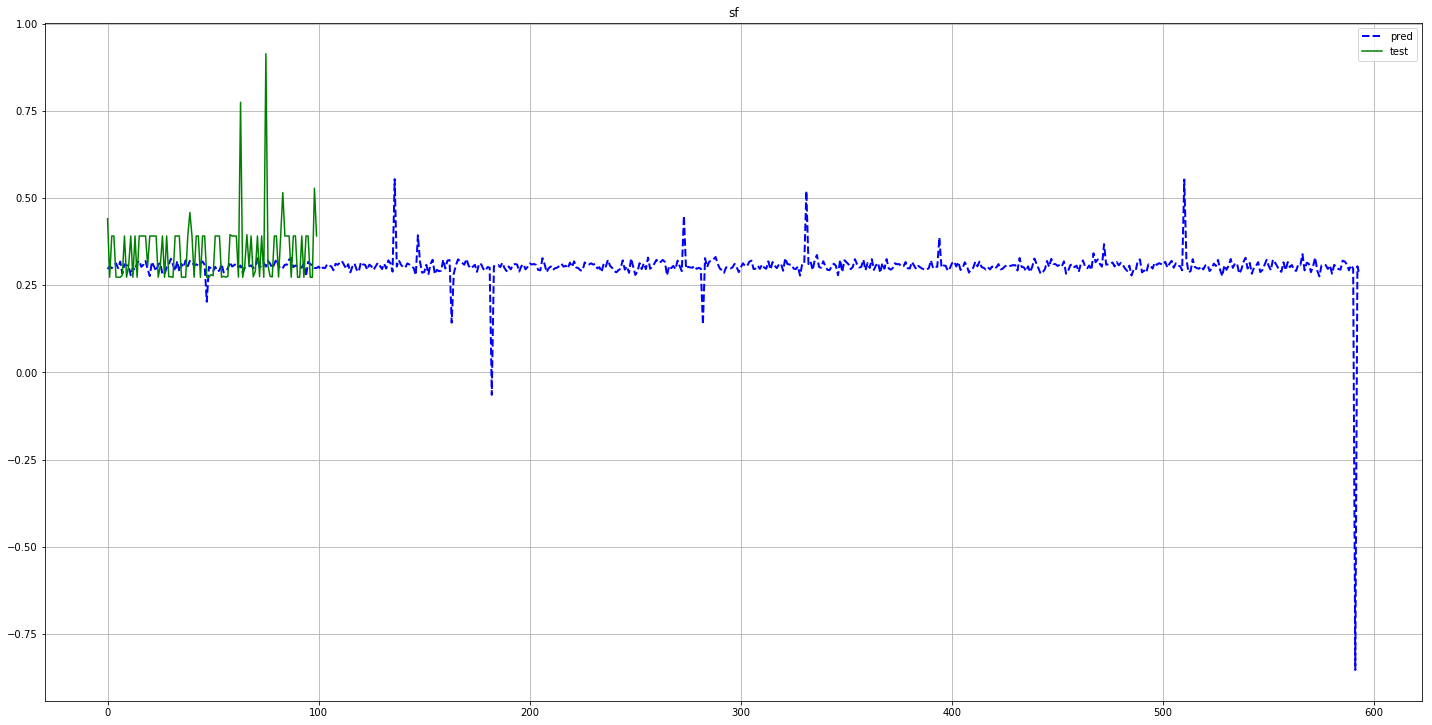

0.296461
0.303717
0.298916
0.305615
0.312691
0.299034
0.317618
0.283399
0.310102
0.307486
0.304725
0.278315
0.30043
0.293064
0.313504
0.320252
0.302652
0.308776
0.319307
0.295632
0.276201
0.316814
0.303819
0.290481
0.309567
0.313434
0.281478
0.282165
0.301565
0.30911
0.325985
0.308083
0.290851
0.319181
0.289466
0.310702
0.301566
0.321535
0.304382
0.319747
0.317512
0.306459
0.309808
0.306577
0.312512
0.318222
0.308121
0.202485
0.302601
0.29792
0.290272
0.302693
0.289554
0.292125
0.310891
0.286614
0.29143
0.297915
0.316404
0.303457
0.307612
0.311651
0.301123
0.306456
0.286338
0.299957
0.30374
0.304603
0.306703
0.299159
0.303099
0.327086
0.301508
0.306227
0.313777
0.303216
0.319911
0.311706
0.298984
0.311002
0.325065
0.306182
0.296668
0.299377
0.308688
0.308904
0.323499
0.327834
0.301927
0.306466
0.304275
0.299859
0.300632
0.312674
0.275511
0.316794
0.310958
0.306553
0.29921
0.299444
0.303404
0.29447
0.300417
0.298673
0.309831
0.306411
0.303793
0.292887
0.31123
0.308507
0.314317
0.319377


In [11]:
######################## 预测
# test = [[ -2.21283262e-02,  -4.22827772e-02,  -1.22634684e-01,  -1.01158189e-01,
#    -1.16706481e-01,  -3.61754572e-02]]
# #t = ss_x.fit_transform(test)
test_pred = model_test(test_x_disorder, sf_Y_test, "sf")
# print(len(test_pred))
for i in range(0,len(test_pred)):
    print(test_pred[i][0])
